<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/WithL2Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       #transforms.RandomHorizontalFlip(0.1),
                                       #transforms.RandomResizedCrop(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [90]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 16
       
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 16
      

        self.pool2 = nn.MaxPool2d(2,2) # output_size = 8
        
        # TRANSITION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
        ) # output_size = 8
  
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x) 
        x = self.convblock4(x)
        
        x = self.pool2(x)    
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [92]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 20, 28, 28]           1,800
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
           Dropout-7           [-1, 20, 28, 28]               0
         MaxPool2d-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 10, 16, 16]             200
           Conv2d-10           [-1, 20, 16, 16]           1,800
             ReLU-11           [-1, 20, 16, 16]               0
      BatchNorm2d-12           [-1, 20, 16, 16]              40
          Dropout-13           [-1, 20, 16, 16]               0
        MaxPool2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

def find_actual_pred_map(model, num=25):
  images=[]
  target_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d , t , p in zip(data, target, pred):
        if t!=p:
          d = d.cpu().numpy()
          t = t.cpu().numpy()
          p = p.cpu().numpy()
          d = (d*0.3081)+0.1307
          images.append(d)
          target_list.append(t)
          pred_list.append(p)
          count+=1
        if count == num:
          return images, target_list, pred_list

In [95]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

images, targ, pred = find_actual_pred_map(model, 25)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.24316516518592834 Batch_id=937 Accuracy=89.84: 100%|██████████| 938/938 [00:18<00:00, 62.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


Loss=0.1011359766125679 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9820/10000 (98.20%)

EPOCH: 2


Loss=0.2181958109140396 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:18<00:00, 51.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.00542883574962616 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:17<00:00, 53.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Loss=0.09809805452823639 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:17<00:00, 52.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.018669992685317993 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:17<00:00, 53.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.07822845876216888 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:18<00:00, 51.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.004047468304634094 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:18<00:00, 52.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.022198542952537537 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:17<00:00, 53.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.012129083275794983 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 52.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.007062762975692749 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:18<00:00, 52.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.008441820740699768 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)

EPOCH: 12


Loss=0.08128954470157623 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:17<00:00, 52.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.11885859817266464 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:17<00:00, 52.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.010931447148323059 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 62.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.025629810988903046 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:17<00:00, 52.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.07004060596227646 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 53.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.062406547367572784 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.06729014217853546 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:17<00:00, 52.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.0039841532707214355 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.003958702087402344 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 52.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.017241492867469788 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 51.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.16457730531692505 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 51.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.052261099219322205 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 52.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.00038698315620422363 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 62.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.06855350732803345 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:18<00:00, 51.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.0015022903680801392 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 51.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 27


Loss=0.006145685911178589 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:18<00:00, 50.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 28


Loss=0.006045550107955933 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:18<00:00, 51.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.11028239130973816 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 51.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.019938454031944275 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:18<00:00, 50.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9945/10000 (99.45%)

EPOCH: 31


Loss=0.0034047365188598633 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 51.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

EPOCH: 32


Loss=0.0013135671615600586 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:18<00:00, 51.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.012775614857673645 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 50.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9925/10000 (99.25%)

EPOCH: 34


Loss=0.002781510353088379 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:18<00:00, 51.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.0022026896476745605 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:17<00:00, 52.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 36


Loss=0.04931876063346863 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:18<00:00, 49.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 37


Loss=0.0032862722873687744 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:18<00:00, 51.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 38


Loss=0.0019619911909103394 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 39


Loss=0.006293922662734985 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]



Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

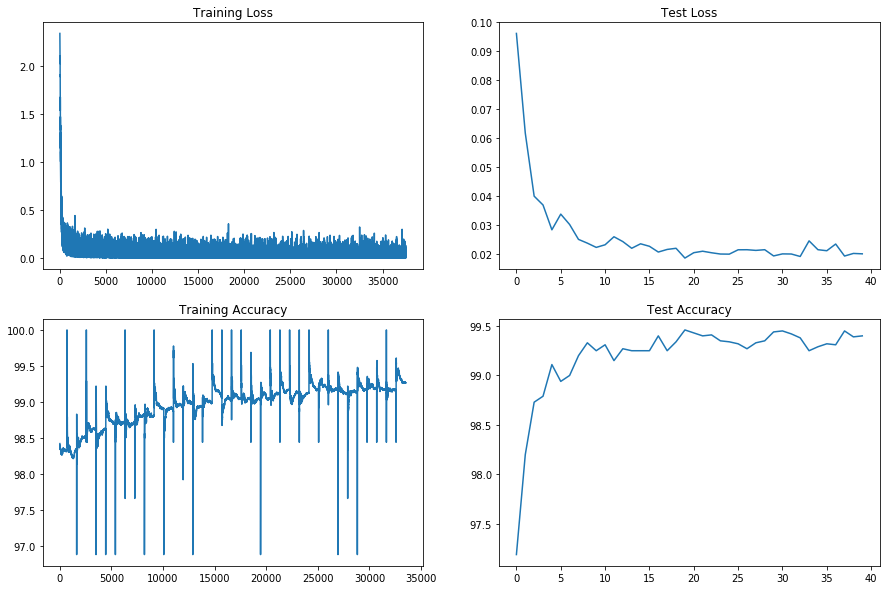

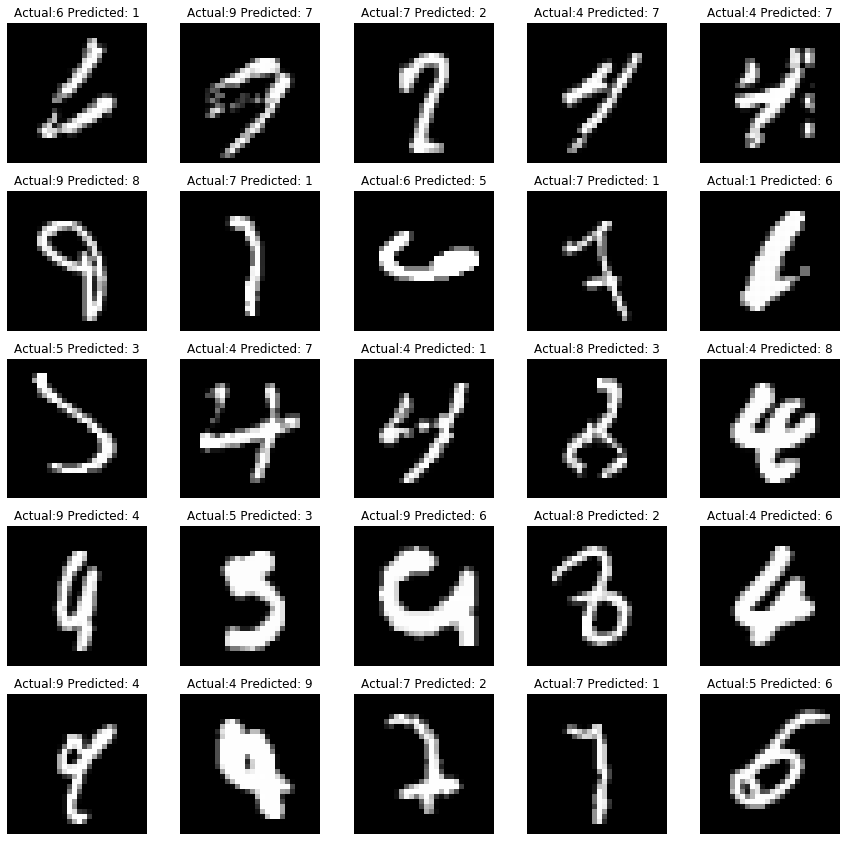

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

fig = plt.figure(figsize=(15, ((25//5)+1)*3))

for i in range(0, 25):
  ax=fig.add_subplot((25//5)+1, 5, i+1)
  ax.imshow(np.rollaxis(images[i], 0, 3).squeeze(), cmap='gray')
  ax.axis('off')
  ax.set_title("Actual:"+str(targ[i])+" Predicted: "+str(pred[i]))

plt.savefig('L2_REG.png')
plt.show()



In [0]:
TARGET: Improve train and test accuracy to reach desired targets within 15 epoch

RESULT: Achieved the target , got 99.45 % test accuracy in EPOCH 13 and there after results remained closer to this accuracy in rest of the epochs.Also the train accuracy slightly improved compared to the previous one.

         Total Params: 9,482
         Best train accuracy: 99.00
         Best test accuracy:  99.45

ANALYSIS: Did not apply drop out in Conv5 layer.Also adding second max pooling earlier has increased the RF to 56